In [ ]:
import os
import gc
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader,TensorDataset,Dataset
import torch.nn.functional as F
from IPython import display
from torchvision.models import resnet18
from torchvision import transforms
from torchvision.ops import StochasticDepth
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
path='Chinese Medicine'
f=os.listdir(path)
x=[]
y=[]
for i,t in enumerate(f):
    fp=os.path.join(path,t)
    for j in os.listdir(fp):
        image=Image.open(os.path.join(fp,j))
        image=image.resize((224,224))
        if image.mode != 'RGB':
            image = image.convert('RGB')
        x.append(np.array(image))
        y.append(i)

In [18]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x          # 图像数据（numpy数组列表）
        self.y = y          # 标签列表
        self.transform = transform  # 图像变换

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]  # 形状为 (200, 300, 3) 的numpy数组
        label = self.y[idx]
        
        # 将numpy数组转换为PIL图像（transforms需要PIL输入）
        image = Image.fromarray(image.astype('uint8'))
        
        # 应用变换（增强）
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. 定义增强变换（训练集用）和基础变换（验证集用）
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # 50%概率水平翻转
    transforms.RandomVerticalFlip(p=0.5),        # 50%概率垂直翻转
    transforms.RandomRotation(degrees=10),        # 随机旋转（-30度到30度）
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移（10%范围）
    transforms.ToTensor(),                       # 转为Tensor并归一化到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet标准化
])

# 验证集/测试集变换（不增强）
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. 划分训练集和验证集（示例比例：80%训练，20%验证）
x_train, x_val, y_train, y_val = tts(x, y, test_size=0.2)

# 4. 创建数据集和数据加载器
train_ds = CustomDataset(x_train, y_train, transform=train_transform)
test_iter = CustomDataset(x_val, y_val, transform=val_transform)

batch_size=64
train_iter = DataLoader(train_ds, batch_size=batch_size, shuffle=True,pin_memory=True)
test_iter = DataLoader(test_iter, batch_size=batch_size, shuffle=False,pin_memory=True)

for images, labels in train_iter:
    print("训练批次图像形状:", images.shape)
    print("标签形状:", labels.shape)
    break

训练批次图像形状: torch.Size([64, 3, 224, 224])
标签形状: torch.Size([64])


In [19]:
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    # 获取预测类别（取概率最高的类别）
    _, predicted = torch.max(y_pred, 1)
    
    # 计算正确预测的数量
    correct = (predicted == y_true).float().sum()
    
    # 计算准确率
    accuracy = correct / y_true.shape[0]
    return accuracy.item() * 100

In [20]:
def train(net:nn.Module, lr=1e-4, epochs=100, is_half=True):
    criterion = nn.CrossEntropyLoss()  # 交叉熵损失
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5)  # 带L2正则化的Adam
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scaler = torch.cuda.amp.GradScaler()
    train_loss_list=[]
    test_loss_list=[]

    plt.ion()
    for epoch in range(epochs):
        net.train()
        train_loss = 0
        train_acc=0
        for i, j in train_iter:
            i,j=i.to(device),j.to(device)
            optimizer.zero_grad()
            # 前向传播
            if is_half:
                with torch.cuda.amp.autocast():
                    p = net(i)
                    loss = criterion(p, j)

                # 反向传播和优化
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                p=net(i)
                loss=criterion(p,j)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_accuracy(p,j)
            
        scheduler.step()
        train_loss /= len(train_iter)
        train_acc /= len(train_iter)

        net.eval()
        with torch.no_grad():
            test_loss=0
            test_acc=0
            for i,j in test_iter:
                i,j=i.to(device),j.to(device)
                if is_half:
                    with torch.cuda.amp.autocast():
                        p = net(i)
                else:
                    p=net(i)
                test_loss += criterion(p, j).item()
                test_acc += calculate_accuracy(p, j)
            test_loss /= len(test_iter)
            test_acc/=len(test_iter)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        #if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], train loss: {train_loss:.5f}, train acc: {train_acc:.3f} test loss: {test_loss:5f}, test acc: {test_acc:.3f}')
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.ylim(0,3)
        plt.xlim(0,epochs)
        plt.plot(range(len(train_loss_list)),train_loss_list,label='train loss')
        plt.plot(range(len(test_loss_list)),test_loss_list,label='test loss')
        plt.legend()
        plt.pause(0.01)
        display.clear_output(wait=True)
    plt.ioff()
    plt.plot(range(len(train_loss_list)),train_loss_list,label='train loss')
    plt.plot(range(len(test_loss_list)),test_loss_list,label='test loss')
    plt.legend()
    plt.show()
    print(f'Epoch [{epoch+1}/{epochs}], train loss: {train_loss:.5f}, train acc: {train_acc:.3f} test loss: {test_loss:5f}, test acc: {test_acc:.3f}')
    print("训练完成!")
    return net

In [21]:
def clear():
    gc.collect()
    torch.cuda.empty_cache()
clear()

In [22]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        # 线性层：用 Xavier 均匀分布初始化权重，偏置置零
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        # 卷积层：用 Kaiming 正态分布初始化权重，偏置置零
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
torch.backends.cudnn.benchmark = True

In [23]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            # 初始层（两个3x3代替7x7）
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [b,64,100,150]
            nn.MaxPool2d(kernel_size=3, stride=2),  # [b,64,50,75]
            nn.Dropout2d(0.05),
            
            # 增加深度块
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # 降维 [b,128,25,38]
            nn.Dropout2d(0.1),
            
            # 深度可分离卷积块
            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # [b,256,13,19]
            nn.Dropout2d(0.15),
            
            # 新增深度块（增加网络深度）
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # [b,512,7,10]
            nn.Dropout2d(0.2),

            # 最终卷积块
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # 保持尺寸
            
            nn.AdaptiveAvgPool2d((1, 1))  # [b,1024,1,1]
        )
        
        # 分类器 - 保持简单
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024,256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

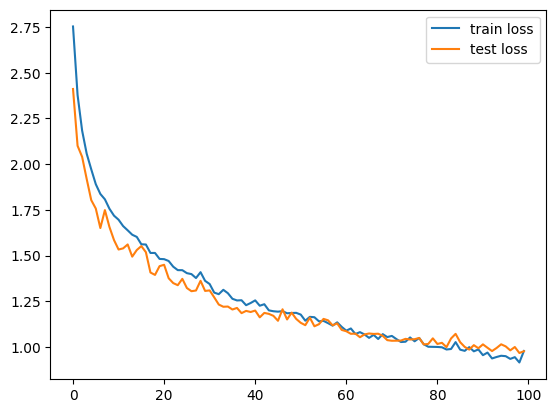

Epoch [100/100], train loss: 0.97771, train acc: 69.026 test loss: 0.976562, test acc: 69.125
训练完成!


In [24]:
clear()
net=CNN(18).to(device)
net.apply(weights_init)
net=train(net)
#torch.save(net,'CNN.pth')

In [25]:
class ResidualCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResidualCNN, self).__init__()
        
        # 增强的特征提取器
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2),  # 添加padding保持尺寸
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 调整池化参数
            
            ResidualBlock(64, 128),
            nn.Dropout2d(0.15),

            ResidualBlock(128, 256),
            nn.Dropout2d(0.2),
            
            ResidualBlock(256, 512),
            nn.Dropout2d(0.25),

            ResidualBlock(512, 1024),
            nn.Dropout2d(0.3),
            
            nn.AdaptiveAvgPool2d((1, 1))  # 更稳定的全局池化
        )
        
        # 优化分类器
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),  # 减少神经元数量
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),  # 降低Dropout率

            nn.Linear(256, 64),  # 减少神经元数量
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1),  # 降低Dropout率
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride>1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity  # 残差连接
        return out

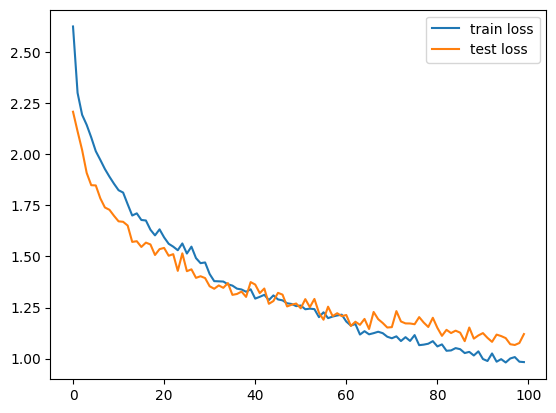

Epoch [100/100], train loss: 0.98293, train acc: 68.589 test loss: 1.120146, test acc: 61.474
训练完成!


In [26]:
clear()
net=ResidualCNN(18).to(device)
net.apply(weights_init)
net=train(net)

In [27]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        
        # 增强的特征提取器
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # 添加padding保持尺寸
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 调整池化参数
            
            ResidualBlock(64, 64),
            nn.Dropout2d(0.15),

            ResidualBlock(64, 64),
            nn.Dropout2d(0.15),

            ResidualBlock(64, 128, stride=2),
            nn.Dropout2d(0.15),

            ResidualBlock(128, 128),
            nn.Dropout2d(0.15),

            ResidualBlock(128, 256, stride=2),
            nn.Dropout2d(0.2),

            ResidualBlock(256, 256),
            nn.Dropout2d(0.2),
            
            ResidualBlock(256, 512, stride=2),
            nn.Dropout2d(0.25),

            ResidualBlock(512, 512),
            nn.Dropout2d(0.25),
            
            nn.AdaptiveAvgPool2d((1, 1))  # 更稳定的全局池化
        )
        
        # 优化分类器
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # 减少神经元数量
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),  # 降低Dropout率

            nn.Linear(256, 64),  # 减少神经元数量
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1),  # 降低Dropout率
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
        )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity  # 残差连接
        return out

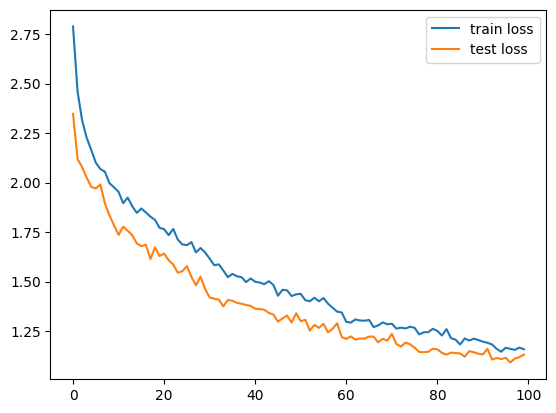

Epoch [100/100], train loss: 1.15811, train acc: 62.615 test loss: 1.131348, test acc: 61.879
训练完成!


In [28]:
clear()
net=ResNet18(18).to(device)
net.apply(weights_init)
net=train(net)

In [32]:
class EfficientAntiOverfitNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientAntiOverfitNet, self).__init__()
        
        # 输入: [batch, 3, 200, 300]
        self.features = nn.Sequential(
            # 初始卷积层
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [b, 32, 100, 150]
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.SiLU(inplace=True),
            
            # 倒残差块组 - 高效特征提取
            self._make_inverted_residual(32, 16, stride=1, expansion=1),
            self._make_inverted_residual(16, 24, stride=2, expansion=6),  # [b, 24, 50, 75]
            self._make_inverted_residual(24, 40, stride=2, expansion=6),  # [b, 40, 25, 38]
            self._make_inverted_residual(40, 80, stride=2, expansion=6),  # [b, 80, 13, 19]
            self._make_inverted_residual(80, 112, stride=1, expansion=6),
            self._make_inverted_residual(112, 192, stride=2, expansion=6),  # [b, 192, 7, 10]
            self._make_inverted_residual(192, 320, stride=1, expansion=6),
            
            # 最后的卷积层
            nn.Conv2d(320, 1280, kernel_size=1, stride=1),
            nn.BatchNorm2d(1280),
            nn.Dropout2d(0.2),
            nn.SiLU(inplace=True),
            
            # 自适应池化
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # 分类器 - 强正则化设计
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),  # 非常高的Dropout率
            nn.Linear(1280, 640),
            nn.BatchNorm1d(640),
            nn.SiLU(inplace=True),
            
            nn.Dropout(0.6),
            nn.Linear(640, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def _make_inverted_residual(self, in_channels, out_channels, stride, expansion):
        layers = []
        expanded_channels = int(in_channels * expansion)
        
        # 扩展层
        if expansion != 1:
            layers.append(nn.Conv2d(in_channels, expanded_channels, 1, bias=False))
            layers.append(nn.BatchNorm2d(expanded_channels))
            layers.append(nn.Dropout2d(0.05))
            layers.append(nn.SiLU(inplace=True))
        
        # 深度可分离卷积
        layers.append(nn.Conv2d(expanded_channels, expanded_channels, 3, 
                               stride, padding=1, groups=expanded_channels, bias=False))
        layers.append(nn.BatchNorm2d(expanded_channels))
        layers.append(nn.SiLU(inplace=True))
        
        # 投影层
        layers.append(nn.Conv2d(expanded_channels, out_channels, 1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        
        # 随机深度 (Stochastic Depth) - 强大的正则化
        if stride == 1 and in_channels == out_channels:
            layers.append(StochasticDepth(p=0.1, mode="row"))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

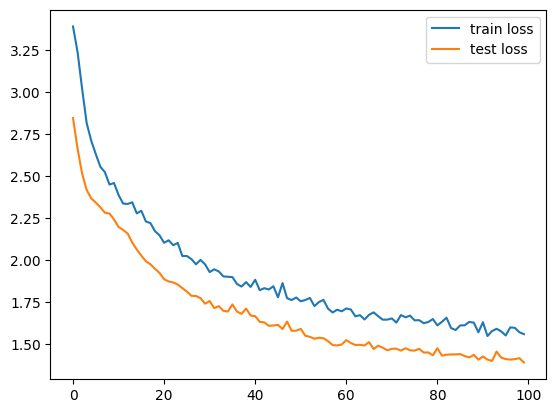

Epoch [100/100], train loss: 1.55730, train acc: 48.047 test loss: 1.388557, test acc: 53.412
训练完成!


In [33]:
clear()
net=EfficientAntiOverfitNet(18).to(device)
net.apply(weights_init)
net=train(net)

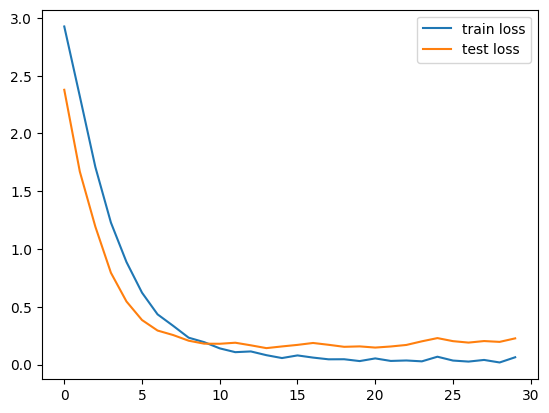

Epoch [30/30], train loss: 0.06415, train acc: 98.851 test loss: 0.227622, test acc: 95.746
训练完成!


In [ ]:
from efficientnet_pytorch import EfficientNet
clear()
net = EfficientNet.from_pretrained('efficientnet-b4')
net._fc = nn.Sequential(
    nn.Dropout(0.8),
    nn.Linear(net._fc.in_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 18)
)
net.to(device)
net=train(net,epochs=30)

In [49]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()/1024**3

0.15585947036743164